IBM created a synthetic dataset that can be use to understand how various factors affect employee attrition and satisfaction. Some of the variables include education, job involvement, performance rating, and work-life balance.

We will explore this dataset and see if there are any significant variables that indeed affect employee satisfaction. Then take it a step further and see if we can rank the variables from most important to the least.


In [149]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pyplot as plt

Import the dataset from a csv file, check the first few rows to make sure everything is in order.

In [100]:
df = pd.read_csv('data/WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Check if there are any columns that have null values. Seems like none of the columns have any missing values. Great! 

In [101]:
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

The fields "StandardHours" and "EmployeeCount" have the same values, 80 and 1 respectively, for all the records. Also, "EmployeeNumber" is an unique identifier for each employee. Let's drop them from the dataset as they do not provide any additional insight.


In [102]:
print(df['EmployeeCount'].value_counts())
print(df['StandardHours'].value_counts())
print(df['Over18'].value_counts())
print(df['EmployeeNumber'].value_counts().count())
df_features = df.drop(labels=['StandardHours', 'EmployeeCount', 'Over18', 'EmployeeNumber'], axis=1)

1    1470
Name: EmployeeCount, dtype: int64
80    1470
Name: StandardHours, dtype: int64
Y    1470
Name: Over18, dtype: int64
1470


The fields "OverTime" and "Attrition" contains two values - Yes/No. We will convert them into binary so that we can use them for modelling as some functions do not work on categorical variables. 

In [103]:
print(df_features['OverTime'].value_counts())
print(df_features['Attrition'].value_counts())
df_features['Attrition'] = df_features[['Attrition']].replace({'Yes':1,'No':0})
df_features['OverTime'] = df_features[['OverTime']].replace({'Yes':1,'No':0})

No     1054
Yes     416
Name: OverTime, dtype: int64
No     1233
Yes     237
Name: Attrition, dtype: int64


In [104]:
print(df_features['OverTime'].value_counts())
print(df_features['Attrition'].value_counts())

0    1054
1     416
Name: OverTime, dtype: int64
0    1233
1     237
Name: Attrition, dtype: int64


In [105]:
df_dummies = pd.get_dummies(df_features[['Department','EducationField', 'Gender','BusinessTravel','JobRole','MaritalStatus']], \
                                prefix=['Department','EducationField', 'Gender','BusinessTravel','JobRole', 'MaritalStatus'], \
                                prefix_sep="_")
df_features =  df_features.join(df_dummies).drop(labels=['Department','EducationField', \
                                      'Gender','BusinessTravel', 'JobRole', 'MaritalStatus'], axis=1)

Next, we will split the dataset into two - features or independent variables (X) and target or dependent variable (y). IN this case, the target variable is "Attrition".

In [106]:
# features
X = df_features.drop('Attrition', axis=1)
# target
y = df_features['Attrition']

In [107]:
X.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,41,1102,1,2,2,94,3,2,4,5993,...,0,0,0,0,0,1,0,0,0,1
1,49,279,8,1,3,61,2,2,2,5130,...,0,0,0,0,1,0,0,0,1,0
2,37,1373,2,2,4,92,2,1,3,2090,...,1,0,0,0,0,0,0,0,0,1
3,33,1392,3,4,4,56,3,1,3,2909,...,0,0,0,0,1,0,0,0,1,0
4,27,591,2,1,1,40,3,1,2,3468,...,1,0,0,0,0,0,0,0,1,0


We have 30 features in our features dataset. The aim is to find out the most important factors out of these that contributing to attrition. Once we know the factors, we will explore their relationship with the target variable.

In [242]:
feature_count=X.shape[1]
X_norm = MinMaxScaler().fit_transform(X)

In [243]:
df_features_scores=pd.DataFrame(np.array(X.columns), columns=['feature_name'])
df_features_scores.head()

,feature_name
0,Age
1,DailyRate
2,DistanceFromHome
3,Education
4,EnvironmentSatisfaction


To determine the most important attrition factors, we will run two feature selection methods and cross-check the findings. 
The first method that we will use for feature selection is Chi-Squared. This will tell us if there is a significant relationship between an independent and the dependant variable. Each feature will be given a score that shows the strength of association.

#### Chi-Squared

In [244]:
chi_selector = SelectKBest(chi2, k='all') #k=feature_count
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

print('{} features selected'.format(len(chi_feature)))


50 features selected


Here is a graphic of the top 15 features affecting Attrition, based on the Chi-Squared score.

In [245]:
df_features_scores['chi2_scores'] = chi_selector.scores_
#df_features_scores.head()
#df_features_scores.sort_values(by='chi2_scores', ascending=False).head(5)#[['feature_name']]

In [246]:

fig=px.bar(df_features_scores.sort_values(by='chi2_scores', ascending=False).head(15),x='feature_name',y='chi2_scores')
fig.update_traces(marker_color='rgb(158,202,225)')

The next feature selection technique that we will apply on the data is Mutual Information Feature Selection. Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable. Similar to chi-squared, Mutual Information Feature Selection also scores each independent variable based on their importance.

#### Mutual Information Feature Selection

In [247]:
mi_selector = SelectKBest(mutual_info_classif, k='all') #k=feature_count
mi_selector.fit(X_norm, y)
mi_support = mi_selector.get_support()
mi_feature = X.loc[:,mi_support].columns.tolist()

print('{} features selected'.format(len(mi_feature)))


50 features selected


In [248]:
df_features_scores['mi_scores'] = mi_selector.scores_
#df_features_scores.head()
#df_features.sort_values(by='mi_scores', ascending=False).head(15)[['feature_name']]

These are the top 15 important features as determined by Mutual Information Feature Selection.

In [249]:
fig=px.bar(df_features_scores.sort_values(by='mi_scores', ascending=False).head(15),x='feature_name',y='mi_scores')
fig.update_traces(marker_color='rgb(158,202,225)')

Let's do a scaled average and see which features are the most important according to both the feature selection methods.

In [250]:
df_features_scores_scaled = pd.DataFrame(MinMaxScaler().fit_transform(df_features_scores.set_index('feature_name')), \
                                  columns=['mi_scores','chi2_scores'])
df_features_scores_scaled['Total'] = np.array(df_features_scores_scaled.sum(axis=1))
df_features_scores_scaled['feature_name'] = df_features_scores['feature_name']
df_features_scores_scaled.sort_values('Total', ascending=False, inplace=True)
df_features_scores_scaled.head(15)


,mi_scores,chi2_scores,Total,feature_name
12,1.000000,0.813968,1.813968,OverTime
46,0.537085,0.646044,1.183128,JobRole_Sales Representative
17,0.090342,1.000000,1.090342,TotalWorkingYears
36,0.247733,0.803098,1.050831,BusinessTravel_Travel_Frequently
9,0.124886,0.920996,1.045882,MonthlyIncome
49,0.481973,0.553146,1.035119,MaritalStatus_Single
7,0.189439,0.601536,0.790975,JobLevel
0,0.061233,0.712938,0.774172,Age
16,0.131926,0.629725,0.761651,StockOptionLevel
21,0.102262,0.568282,0.670544,YearsInCurrentRole


In [251]:
fig = px.bar(df_features_scores_scaled.sort_values(by='Total', ascending=False).head(15),\
       x='feature_name',y='Total')
fig.update_traces(marker_color='rgb(158,202,225)')

In [292]:
def get_pc(col_name, churn=-99):
    df_plot = pd.DataFrame()
    
    df_plot=df.groupby([col_name,'Attrition']).count()['EmployeeNumber'].reset_index()

    df_plot['EmployeePercent'] = df_plot \
            .apply(lambda x: (x['EmployeeNumber']*100.0/ \
                   df_plot[(df_plot[col_name]==x[col_name])]['EmployeeNumber'].sum()).round(2) \
                   , axis=1)

    if churn==1 or churn==0:
        if churn==1:
            df_plot=df_plot[df_plot['Attrition']=='Yes']
        else:
            df_plot=df_plot[df_plot['Attrition']=='No']
            
    return df_plot


def show_data_labels(ax):
    for rect in ax.patches:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height+1 , '{}%'.format(height), ha='center', va='bottom')


[Text(0, 0.5, 'Attrition Count')]

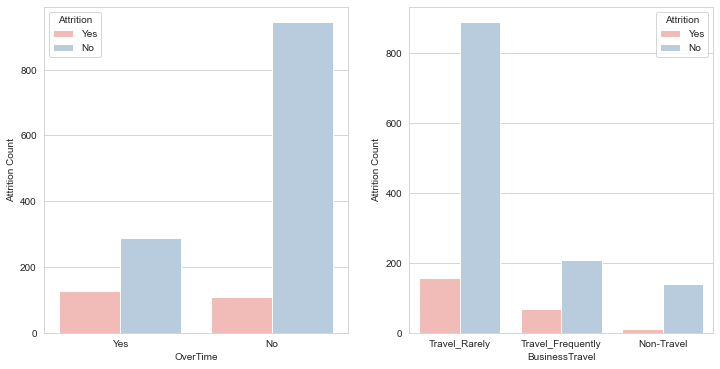

In [334]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2) 

ax1=sns.countplot(x="OverTime", hue="Attrition", data=df, palette="Pastel1", ax=ax[0])
ax1.set(ylabel='Attrition Count')

ax2=sns.countplot(x="BusinessTravel", hue="Attrition", data=df, palette="Pastel1", ax=ax[1])
ax2.set(ylabel='Attrition Count')

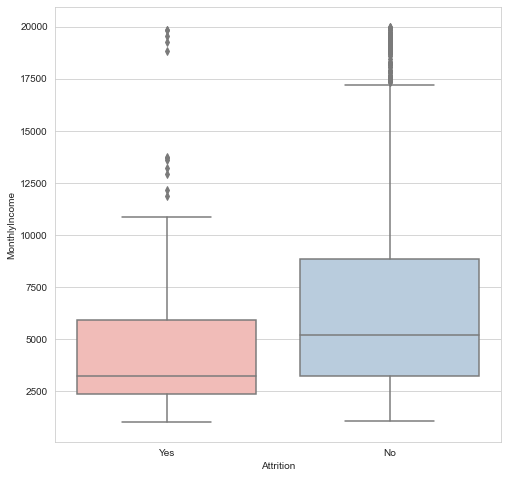

In [313]:
plt.figure(figsize=(8,8))
sns.boxplot(y="MonthlyIncome", x="Attrition", data=df, palette="Pastel1")

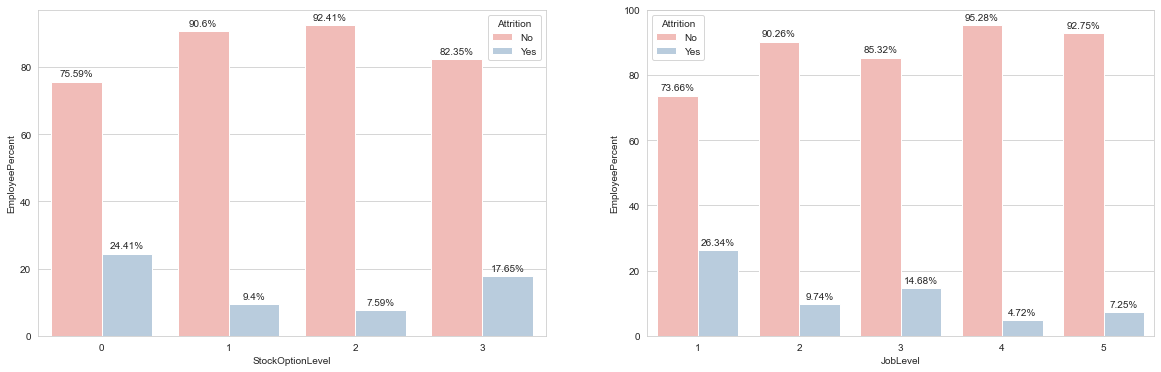

In [293]:
fig, ax = plt.subplots(figsize=(20, 6), ncols=2) 

ax1=sns.barplot(data=get_pc('StockOptionLevel'), x="StockOptionLevel", y="EmployeePercent", \
                 hue="Attrition", palette="Pastel1", ax=ax[0]) 
show_data_labels(ax1) 

ax2=sns.barplot(data=get_pc('JobLevel'), x="JobLevel", y="EmployeePercent", \
                 hue="Attrition", palette="Pastel1", ax=ax[1])
show_data_labels(ax2)   

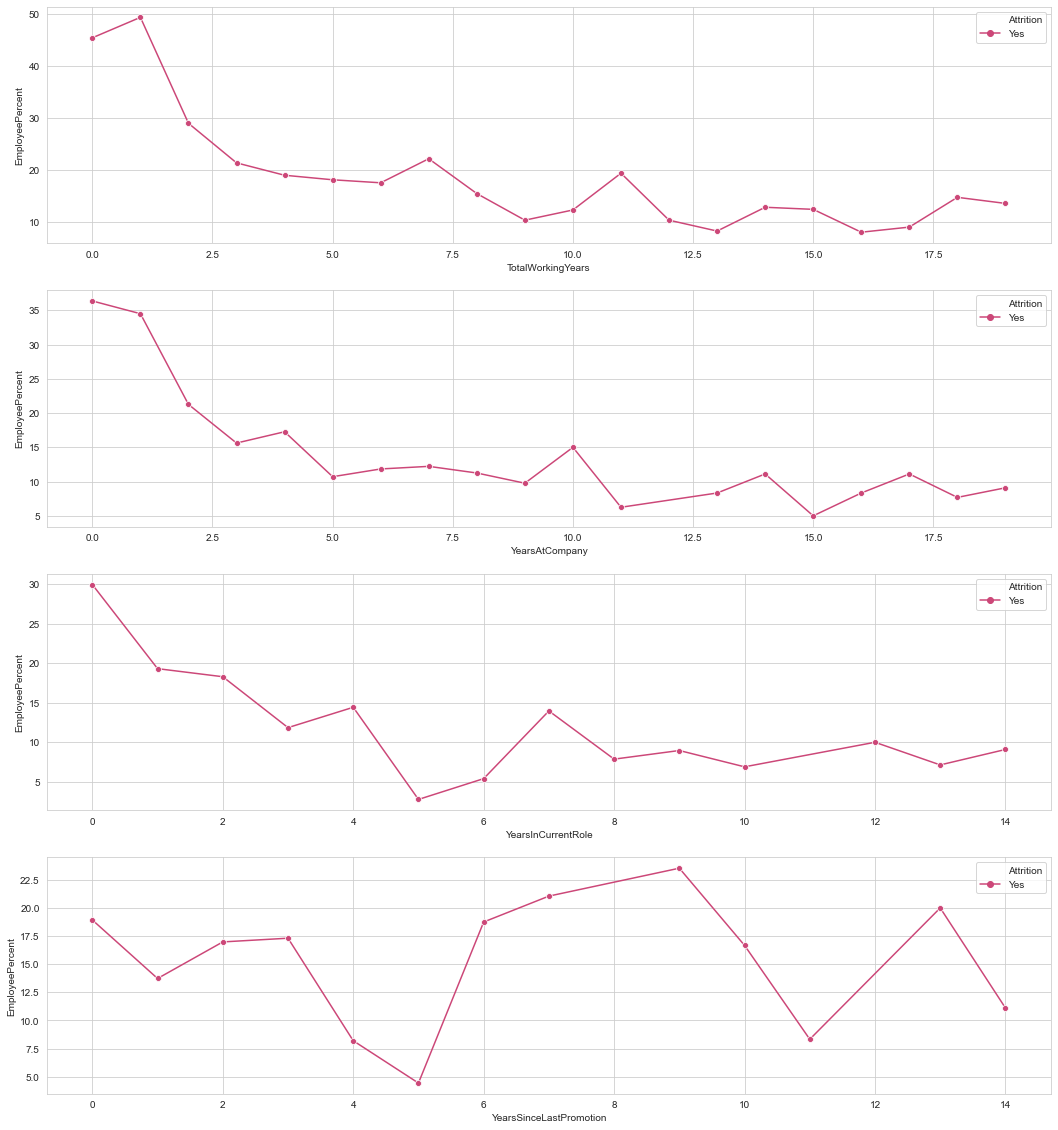

In [331]:
fig, ax = plt.subplots(figsize=(18, 20), ncols=1, nrows=4) 
sns.set_style("whitegrid") #white, dark, whitegrid, darkgrid, ticks

df_plot = get_pc('TotalWorkingYears',1)
df_plot = df_plot[df_plot['TotalWorkingYears']<20]
sns.lineplot(data=df_plot, x="TotalWorkingYears", y="EmployeePercent", hue="Attrition", \
             palette="plasma", style="Attrition", markers=True, dashes=False, ax=ax[0])
                
df_plot = get_pc('YearsAtCompany',1)
df_plot = df_plot[df_plot['YearsAtCompany']<20]
sns.lineplot(data=df_plot, x="YearsAtCompany", y="EmployeePercent", hue="Attrition", \
             palette="plasma", style="Attrition", markers=True, dashes=False, ax=ax[1])

df_plot = get_pc('YearsInCurrentRole',1)
df_plot = df_plot[df_plot['YearsInCurrentRole']<15]
sns.lineplot(data=df_plot, x="YearsInCurrentRole", y="EmployeePercent", hue="Attrition", \
             palette="plasma", style="Attrition", markers=True, dashes=False, ax=ax[2])
                
df_plot = get_pc('YearsSinceLastPromotion',1)
df_plot = df_plot[df_plot['YearsSinceLastPromotion']<15]
sns.lineplot(data=df_plot, x="YearsSinceLastPromotion", y="EmployeePercent", hue="Attrition", \
             palette="plasma", style="Attrition", markers=True, dashes=False, ax=ax[3])

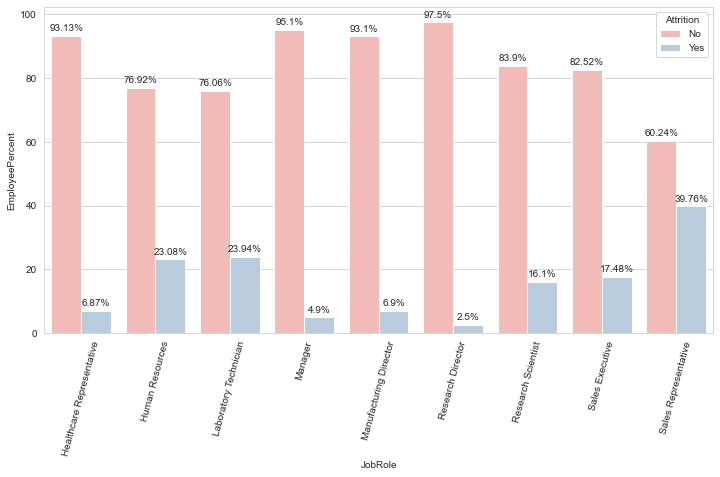

In [294]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=get_pc('JobRole'), x="JobRole", y="EmployeePercent", hue="Attrition", palette="Pastel1")
ax.set_xticklabels(ax.get_xticklabels(), rotation=75);
show_data_labels(ax)    

<Figure size 1152x432 with 0 Axes>

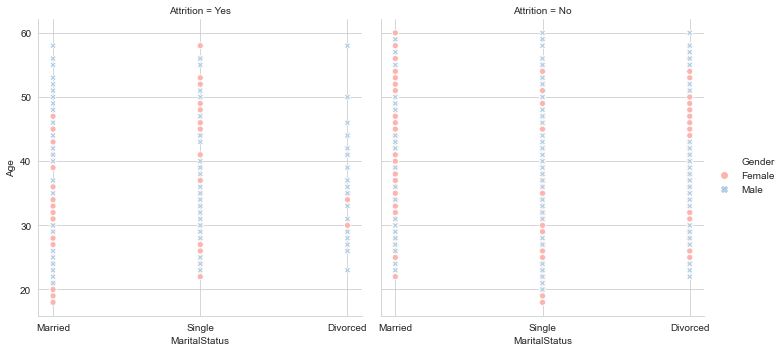

In [328]:
plt.figure(figsize=(16,6));
sns.relplot(data=df, x="MaritalStatus", y="Age", col="Attrition", \
            hue="Gender", style="Gender", kind="scatter", palette='Pastel1');